Canny Steps:
1. Convolve image f with a Gaussian G of scale σ
2. Filter with Sobel kernel in both horizontal (gx) and vertical direction (gy)
3. Estimate the local edge gradient for each pixel
4. Find the location of the edge using zero crossing
5. Compute the magnitude of the edge at that location using Threshold edges with hysteresis to avoid “streaking problem” (breaking up of the edge contour caused by operator fluctuating above and below the threshold).

Thresholding with hysteresis: 
1. Two thresholds are set, T1 and T2, T1<T2 
2. Responses above T2 are actual edges 
3. Responses below T1 are not edges 
4. Responses between T1 and T2 are edges if  they are connected to any edges of the strong response.


### Helper functions:

In [ ]:
from typing import List
import math
import cv2
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["figure.figsize"] = (14,8)

In [ ]:
def plot_figure(image_list: List[np.ndarray], title_list: List[str], height: int, width: int, cmap: str='gray'):
  """ Plot list of images - inline plotting
      Args:
        - image_list (list): list of images to plot
        - title_list (list): list of titles for each image
        - height (int): number of rows for the plot
        - width (int): number of columns for the plot
        - cmap (string): cmap of plotting ('gray', 'bgr', 'rgb')
  """
  assert len(image_list) == len(title_list)
  assert height > 0
  assert width > 0
  for i in range(len(image_list)):
      
      if cmap == 'gray':
          plt.subplot(height, width, i + 1), plt.imshow(image_list[i], cmap=cmap,  vmin=0 , vmax=255 )
      elif cmap == 'rgb':
          plt.subplot(height, width, i + 1), plt.imshow(image_list[i])
      elif cmap == 'bgr':
          plt.subplot(height, width, i + 1), plt.imshow(cv2.cvtColor(image_list[i], cv2.COLOR_BGR2RGB))
      else:
          plt.subplot(height, width, i + 1), plt.imshow(image_list[i], cmap=cmap)
          
      plt.title(title_list[i])
      plt.xticks([]), plt.yticks([])
  plt.show()

In [ ]:
def zero_crossing(image):
    z_c_image = np.zeros(image.shape)

    # For each pixel, count the number of positive
    # and negative pixels in the neighborhood

    for i in range(1, image.shape[0] - 1):
        for j in range(1, image.shape[1] - 1):
            negative_count = 0
            positive_count = 0
            neighbour = [image[i + 1, j - 1], image[i + 1, j], image[i + 1, j + 1], image[i, j - 1], image[i, j + 1],
                         image[i - 1, j - 1], image[i - 1, j], image[i - 1, j + 1]]
            d = max(neighbour)
            e = min(neighbour)
            for h in neighbour:
                if h > 0:
                    positive_count += 1
                elif h < 0:
                    negative_count += 1

            # If both negative and positive values exist in
            # the pixel neighborhood, then that pixel is a
            # potential zero crossing

            z_c = ((negative_count > 0) and (positive_count > 0))

            # Change the pixel value with the maximum neighborhood
            # difference with the pixel

            if z_c:
                if image[i, j] > 0:
                  z_c_image[i, j] = image[i, j] + np.abs(e)
                elif image[i, j] < 0:
                  z_c_image[i, j] = np.abs(image[i, j]) + d

    # Normalize and change datatype to 'uint8' (optional)
    z_c_norm = z_c_image / z_c_image.max() * 255
    z_c_image = np.uint8(z_c_norm)

    return z_c_image

### Cany with zero-crossings:

In [ ]:
# it takes a gray scale image
# plaese enter thresholds T1 and T2 as ratios, where T1 < T2

def canny(gray,t1,t2,sigma):

  # Convolve image f with a Gaussian G of scale σ
  # computing the size of the kernal using the sigma
  k = 2 * math.floor(3*sigma) + 1
  print(k)
  img_gaussian = cv2.GaussianBlur(gray, (k, k), sigma)
  
  
  # Filter with Sobel kernel in both horizontal (gx) and vertical direction (gy)
  img_sobelx = cv2.Sobel(np.float32(img_gaussian ), cv2.CV_64F, 1, 0, 3)
  img_sobely = cv2.Sobel(np.float32(img_gaussian ), cv2.CV_64F, 0, 1, 3)
  img_sobel = img_sobelx + img_sobely
  
  # Estimate the local edge gradient for each pixel
  magnitude, angle  = cv2.cartToPolar(img_sobelx, img_sobely , angleInDegrees = True)

  # Find the location of the edge using zero crossing
  # first apply the lapalcian on the gaussian blurred image to get the second derivative of the image 
  # then using the zero-crossing function to localize the positions of edges by checking if the neighbourhood 
  # of that pixel contains negative values and positive values to indicate that it is an actual zero crossing 
  laplacian = cv2.Laplacian(img_gaussian, cv2.CV_64F)
  img_zc = zero_crossing(laplacian)

  # Compute the magnitude of the edge at that location using Threshold edges with hysteresis to avoid “streaking problem”
  # tune the values of T1 and T2 according to the maximum value of the magnitude
  mag_max = magnitude.max()
  T1 = mag_max *t1  #low limit 
  T2 = mag_max *t2 # high limit 

  # Thresholding with hysteresis
  for i in range(magnitude.shape[0]):
    for j in range(magnitude.shape[1]):
      # using the zero-crossings to better localize the edge location
      # if the pixel is not indicated as edge in the zero-crossings, then we set the magnitude to zero.
      if img_zc[i,j] > T1:
        mag = magnitude[i,j]
        if mag < T1: # not an edge 
          magnitude[i,j] = 0
        elif mag >= T2: # strong edge
          magnitude[i,j] = T2
        elif mag < T2 and mag > T1: # weak edge check if it is connected to a strong edge 
          # check the 8 neighbours, if any is a strong edge, the pixel become a strong edge 
          # otherwise it's mag is set to zero 
          dx =[1 , -1 , 0 , 0 , -1 , 1 , -1 , -1]
          dy =[0 , 0 , -1 , 1 , 1 , 1 , -1 , 1]
          for x in range(len(dx)):
            nx = i + dx[x]
            ny = j + dy[x]
            magnitude[i,j] = 0
            if nx >= 0 and nx < magnitude.shape[0] and ny >= 0 and ny < magnitude.shape[1] and magnitude[nx,ny] >= T2:
              magnitude[i,j] = T2
      else:
        magnitude[i,j] = 0

  magnitude = ( magnitude > 0 ) * 150
  return magnitude 


9


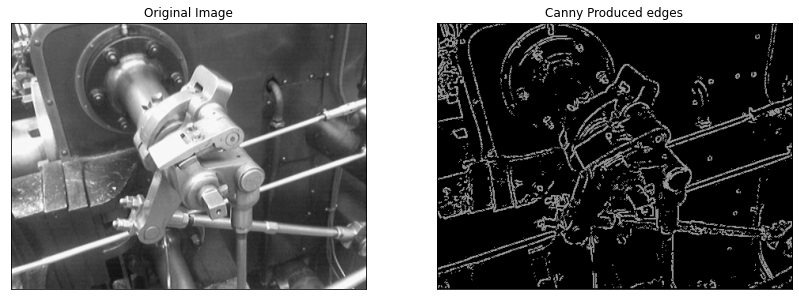

In [ ]:
img = cv2.imread('/content/carpart.PNG')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

canny_image = canny(gray , 0.1 , 0.15 , 1.4)


plot_figure([gray, canny_image],['Original Image','Canny Produced edges'], 1, 2)


13


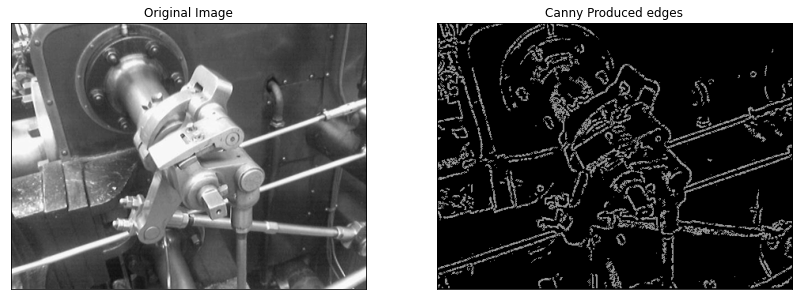

In [ ]:
img = cv2.imread('/content/carpart.PNG')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

canny_image = canny(gray , 0.15 , 0.18 , 2)

plot_figure([gray, canny_image],['Original Image','Canny Produced edges'], 1, 2)

19


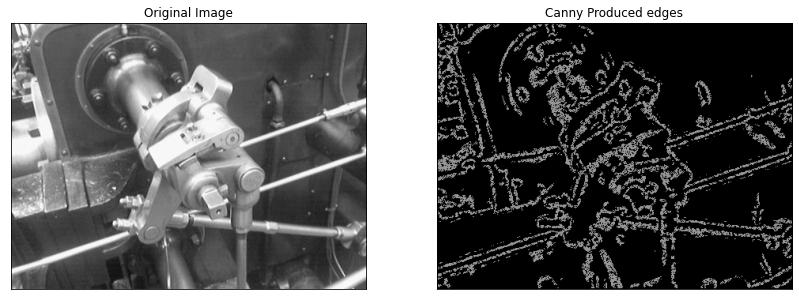

In [ ]:
# increasing blurring produces a less localized edges and removes some of the edges too for the same values of thresholds
img = cv2.imread('/content/carpart.PNG')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

canny_image = canny(gray , 0.15 , 0.18 , 3)

plot_figure([gray, canny_image],['Original Image','Canny Produced edges'], 1, 2)

13


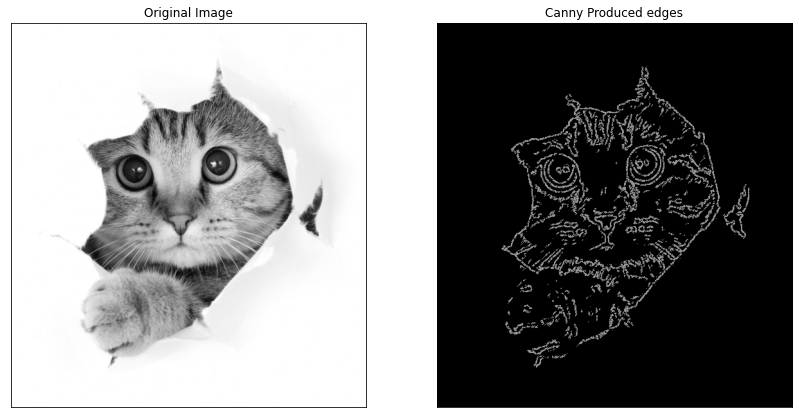

In [ ]:
img = cv2.imread('/content/Funny_Cat.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

canny_image = canny(gray , 0.1 , 0.15 , 2)

plot_figure([gray, canny_image],['Original Image','Canny Produced edges'], 1, 2)

9


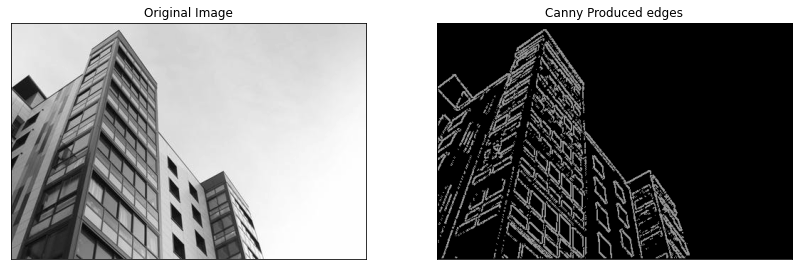

In [ ]:
img = cv2.imread('/content/building.jpeg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

canny_image = canny(gray , 0.1 , 0.15 , 1.4)

plot_figure([gray, canny_image],['Original Image','Canny Produced edges'], 1, 2)

### Canny with Non-maximum supression:

In [ ]:
# selecting the neighbours of the target pixel according to the gradient direction

def neighbours(angle , x , y ): # angles are from 0 - 180
  
  # edge in the x_direction  
  if (angle <= 22.5) or (angle>(22.5 + 135) and angle <=(22.5 + 180)) :
    nx1, ny1 = x - 1 , y
    nx2, ny2 = x + 1, y

  # right- diagonal direction 
  elif angle >22.5 and angle <=(22.5 + 45):
    nx1, ny1 = x - 1, y - 1
    nx2, ny2 = x + 1, y + 1
  
  # edge in y-direction:
  elif angle >(22.5 + 45) and angle <=(22.5 + 90):
    nx1, ny1 = x , y - 1
    nx2, ny2 = x , y + 1

  # left-diagonal direction
  elif angle >(22.5 + 90) and angle <=(22.5 + 135):
    nx1, ny1 = x - 1 , y + 1
    nx2, ny2 = x + 1 , y - 1

  return nx1, ny1 , nx2, ny2
            

In [ ]:
# it takes a gray scale image
# plaese enter thresholds T1 and T2 as ratios, where T1 < T2

def canny_supress(gray,t1,t2,sigma):

  # Convolve image f with a Gaussian G of scale σ
  # computing the size of the kernal using the sigma 
  k = 2 * math.floor(3*sigma) + 1
  print(k)
  img_gaussian = cv2.GaussianBlur(gray, (k, k), sigma)
  
  
  # Filter with Sobel kernel in both horizontal (gx) and vertical direction (gy)
  # used to compute the gradiant at each pixel 
  img_sobelx = cv2.Sobel(np.float32(img_gaussian ), cv2.CV_64F, 1, 0, 3)
  img_sobely = cv2.Sobel(np.float32(img_gaussian ), cv2.CV_64F, 0, 1, 3)
  img_sobel = img_sobelx + img_sobely
  
  
  # Estimate the local edge gradient for each pixel
  # get the value of the magnitdue and angle 
  magnitude, angle  = cv2.cartToPolar(img_sobelx, img_sobely , angleInDegrees = True)
  


  # Compute the magnitude of the edge at that location using Threshold edges with hysteresis to avoid “streaking problem”
  # tune the values of T1 and T2 according to the maximum value of the magnitude 
  mag_max = magnitude.max()
  T1 = mag_max *t1  #low limit 
  T2 = mag_max *t2 # high limit 

  # non-maximum supression
  # Get the neighbours that have the same gradient direction as the pixel in consideration  
  for i in range(magnitude.shape[0]):
    for j in range(magnitude.shape[1]):
      mag = magnitude[i,j]
      ang = angle[i,j]
      
      # limit the range of the angle to be 0 - 180 degrees
      if abs(ang) > 180:
        ang = abs(ang - 180)
      else:
        ang = abs(ang)

      # get the neighbours 
      nx1 , ny1 , nx2 , ny2 = neighbours(ang , i , j )
      # check index boundaries then check the value of each of the two neighbours, if mag of the pixel smaller than either of them we should e;iminate mag
      if nx1 >= 0 and nx1 < magnitude.shape[0] and ny1 >= 0 and ny1 < magnitude.shape[1] and magnitude[nx1,ny1] > mag:
        magnitude[i,j] = 0
      elif nx2 >= 0 and nx2 < magnitude.shape[0] and ny2 >= 0 and ny2 < magnitude.shape[1] and magnitude[nx2,ny2] > mag:
        magnitude[i,j] = 0

  # Thresholding with hysteresis
  for i in range(magnitude.shape[0]):
    for j in range(magnitude.shape[1]):
        mag = magnitude[i,j]
        if mag < T1:
          magnitude[i,j] = 0
        elif mag >= T2:
          magnitude[i,j] = T2
        elif mag < T2 and mag > T1:
          dx =[1 , -1 , 0 , 0 , -1 , 1 , -1 , -1]
          dy =[0 , 0 , -1 , 1 , 1 , 1 , -1 , 1]
          for x in range(len(dx)):
            nx = i + dx[x]
            ny = j + dy[x]
            magnitude[i,j] = 0
            if nx >= 0 and nx < magnitude.shape[0] and ny >= 0 and ny < magnitude.shape[1] and magnitude[nx,ny] >= T2:
              magnitude[i,j] = T2


  magnitude = ( magnitude > 0 ) * 150
  return magnitude 


9


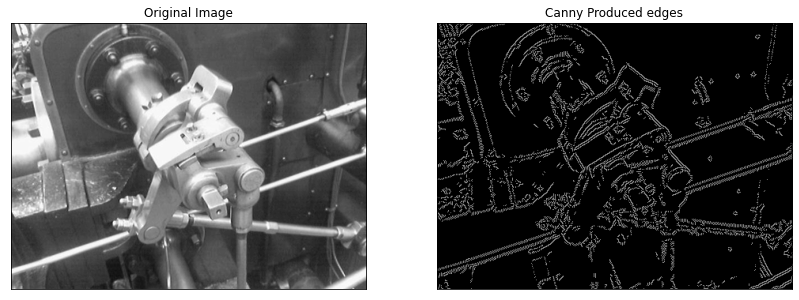

In [ ]:
img = cv2.imread('/content/carpart.PNG')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

canny_image = canny_supress(gray , 0.1 , 0.15 , 1.4)

plot_figure([gray, canny_image],['Original Image','Canny Produced edges'], 1, 2)

9


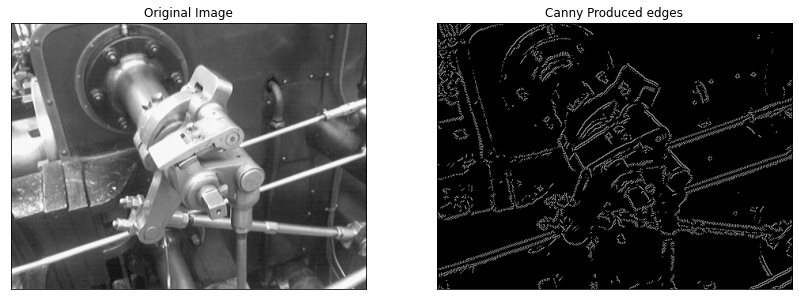

In [ ]:
img = cv2.imread('/content/carpart.PNG')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

canny_image = canny_supress(gray , 0.1 , 0.2 , 1.4)

plot_figure([gray, canny_image],['Original Image','Canny Produced edges'], 1, 2)

13


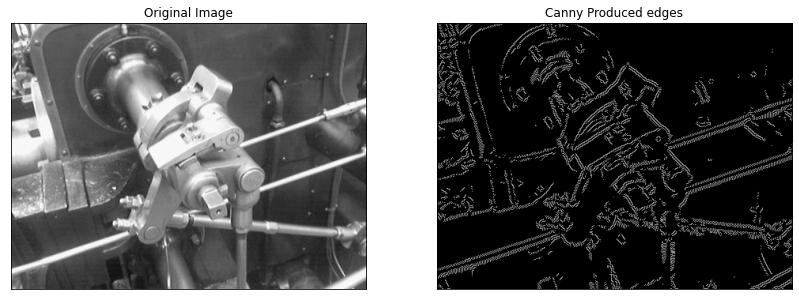

In [ ]:
img = cv2.imread('/content/carpart.PNG')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

canny_image = canny_supress(gray , 0.15 , 0.18 , 2)

plot_figure([gray, canny_image],['Original Image','Canny Produced edges'], 1, 2)

13


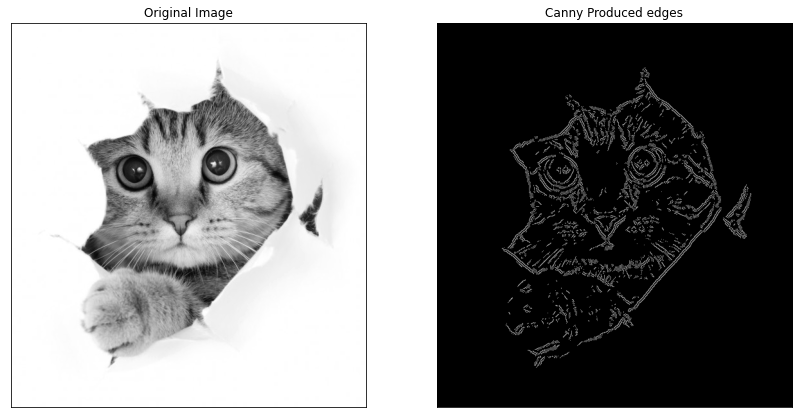

In [ ]:
img = cv2.imread('/content/Funny_Cat.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

canny_image = canny_supress(gray , 0.1 , 0.15 , 2)

plot_figure([gray, canny_image],['Original Image','Canny Produced edges'], 1, 2)

9


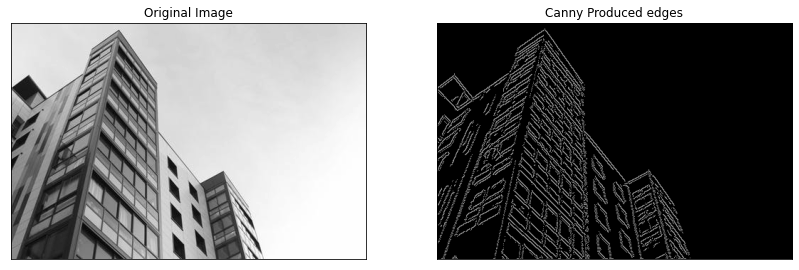

In [ ]:
img = cv2.imread('/content/building.jpeg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

canny_image = canny_supress(gray , 0.1 , 0.15 , 1.4)

plot_figure([gray, canny_image],['Original Image','Canny Produced edges'], 1, 2)

Comment:

For the same paramters, non-maximum suppression gave a little bit wider edges but the edges are more connected (cuts in egdes are less) and somehow less fizzy.